# Linear Regression

## Princeton Salary Datasets

- In this task, we will study the impact of various factors (education, experience and gender) on salaries in academia.
- The dataset is a historic dataset of salaries in an academic department and is easy to study.

In [1]:
import pandas as pd
data = pd.read_csv("http://data.princeton.edu/wws509/datasets/salary.dat", sep='\s+')

Note that we just downloaded a dataset from the Internet straight into `pandas`.

### Salary Distribution

As always, we start with exploring the dataset for a little.

In [2]:
print len(data), 'rows'
data.head()

52 rows


,sx,rk,yr,dg,yd,sl
0,male,full,25,doctorate,35,36350
1,male,full,13,doctorate,22,35350
2,male,full,10,doctorate,23,28200
3,female,full,7,doctorate,27,26775
4,male,full,19,masters,30,33696


First note we only have 52 rows, which is very little.

As we can read on the [Princeton website](http://data.princeton.edu/wws509/datasets/#salary), these columns mean the following:
- sx = Sex: male or female,
- rk = Rank: full, associate or assistant professor,
- yr = Number of years in current rank,
- dg = Highest degree: doctorate or masters,
- yd = Number of years since highest degree was earned,
- sl = Academic year salary, in dollars.

One of our initial questions is what the distributon of salaries is.

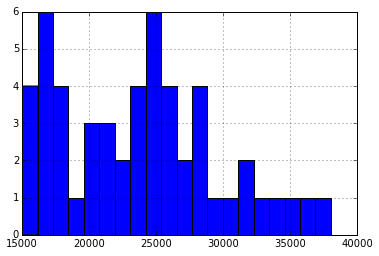

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline
f = data.sl.hist(bins=20)

### What correlates with salary?

Next, we would want to what factors may be correlated with salary.  We would expect that as experience or education increases, the salary should increases as well.

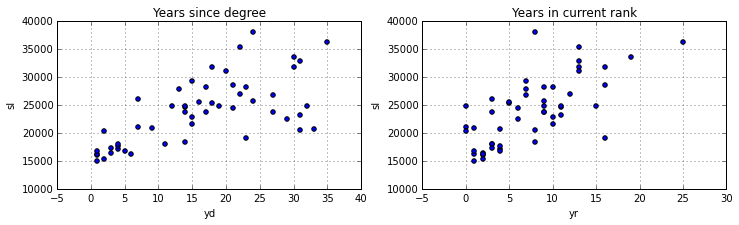

In [4]:
fig, axes = plt.subplots(ncols=2) 
f = data.plot(kind='scatter', x='yd', y='sl', ax=axes[0], title="Years since degree", figsize=(12,3))
f = data.plot(kind='scatter', x='yr', y='sl', ax=axes[1], title="Years in current rank")

Most importantly, while using **linear** regression, we should see if the relationship is **linear**.  Does every increase in X lead to a constant increase in Y?  We may expect for the first 5-10 year of experience this true, but perhaps after 10 year the salaries stop increasing or jump dramatically.  Linear regression would be unable to capture these nonlinearaties. 

### sklearn

In [5]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
X, y = data[['yr', 'yd']], data.sl
model.fit(X, y)
model.score(X, y)  # for regression, this is R2

0.5782019226431887

In [6]:
# intercept of model
model.intercept_

16555.689673113389

In [7]:
# slope per dimension
model.coef_

array([ 489.29445905,  222.25130361])

In [8]:
# these go with each dimension
coefs = zip(model.coef_, X.columns)
coefs

[(489.29445904610566, 'yr'), (222.25130361475976, 'yd')]

In [9]:
# so the linear model would be the following
print "sl = %.1f + " % model.intercept_ + \
    " + ".join("%.1f %s" % coef for coef in coefs)

sl = 16555.7 + 489.3 yr + 222.3 yd


Meaning, the base salary is almost \$17K, each year in the current position adds another \$500, and each year after your degree adds another \$200.

#### Cross-validation
Supervised problems, like linear regression, always require a training and a testset, to avoid having overfitted your model.


In [10]:
from sklearn.cross_validation import train_test_split
for k in xrange(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8)
    print model.fit(X_train, y_train).score(X_test, y_test).round(3), 

0.623 0.61 0.555 0.761 0.674 0.801 -0.09 0.2 0.619 0.508


These are not so great numbers, and not that consistent either. This is not that surprising if you realize how little samples we have (52) and how little structure we saw in the plots.

### Categorical features

- We'd like to somehow incorporate the categorical features as well, even though they're not numerical values
- One way to do this is adding columns for each category, with a boolean flag
- An easy off-the-shelves solution is `patsy`, a library for describing statistical models using symbolic formulas and building design matrices. Patsy is very similar to `R`.

In [11]:
from patsy import dmatrices

We'd like to try a linear model predicting the salary, with features sex, years in rank and rank.

In [12]:
y, X = dmatrices('sl ~ sx + yr + rk', data=data, return_type='dataframe')

In [13]:
X.head()

,Intercept,sx[T.male],rk[T.associate],rk[T.full],yr
0,1,1,0,1,25
1,1,1,0,1,13
2,1,1,0,1,10
3,1,0,0,1,7
4,1,1,0,1,19


X is now our feature matrix
- `Intercept` always contains a one, which offers a convenient way of computing the intercept
- `sx[T.male]` is 1 if `sx == 'male'`, and 0 otherwise
- `rk[T.associate]` is 1 if `rk == 'associate'`, and 0 otherwise
- `rk[T.full]` is 1 if `rk == 'full'`, and 0 otherwise
- `yr` is just `yr`


Note that the two `rk` columns can never be both one. If they're both zero, then `rk == assistant`.

Also note that `y` is now a one-column dataframe.

In [14]:
y.head()

,sl
0,36350
1,35350
2,28200
3,26775
4,33696


In [15]:
model = LinearRegression()
model.fit(X, y).score(X, y)

0.8461760134902937

Better score for sure!

In [16]:
print model.intercept_
print model.coef_

[ 16430.96168389]
[[    0.          -524.14921086  4373.91539051  9483.84186941
    390.93575731]]


Note that the first coefficient is zero, since we already fitted an intercept. 

Alternatively, we can do:

In [17]:
model = LinearRegression(fit_intercept=False)
print model.fit(X, y).score(X, y)
print model.intercept_
print model.coef_

0.84617601349
0.0
[[ 16430.96168389   -524.14921086   4373.91539051   9483.84186941
     390.93575731]]


Also note that `model.coef_` is now a matrix, since we gave the model a dataframe `y` instead of a series. It is possible to fit more `y`s at once.

In [18]:
coefs = zip(model.coef_[0], X.columns)
print "sl = " + " + ".join("%.1f %s" % coef for coef in coefs)

sl = 16431.0 Intercept + -524.1 sx[T.male] + 4373.9 rk[T.associate] + 9483.8 rk[T.full] + 390.9 yr


**You should now be able to complete the exercises at the bottom of this notebook.**

<hr>

### statsmodels

- Statsmodels is a relatively new package that provides convenient utilities for investigating the results of a model. 
- It uses `patsy` to provide R formula syntax

A formula allows you to write a functional relationship between variables.  
Example:
```R
Y ~ X1 + X2 + X3
```

It automatically assumes there  is an intercept term. You can make this explicit by using 

```R
Y ~ 1 + X1 + X2 + X3
```

In [19]:
import statsmodels.formula.api as sm

In [20]:
model = sm.ols(formula="sl ~ yr", data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sl   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     48.22
Date:                Sun, 12 Jul 2015   Prob (F-statistic):           7.34e-09
Time:                        14:04:00   Log-Likelihood:                -507.38
No. Observations:                  52   AIC:                             1019.
Df Residuals:                      50   BIC:                             1023.
Df Model:                           1                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1.817e+04   1003.658     18.100      0.000      1.62e+04  2.02e+04
yr           752.7978    108.409      6.944      0.000       535.051   970.544
==============================================================================
Omnibus:                        5.716   Durbin-Watson:                   1.430
Prob(Omnibus):                  0.057   Jarque-Bera (JB):                5.015
Skew:                           0.509   Prob(JB):                       0.0815
Kurtosis:                       4.130   Cond. No.                         15.8
==============================================================================
"""

We can use categorical features as well, and `statsmodels` will use `patsy` for that just as we have been before.

In [21]:
model = sm.ols(formula="sl ~ sx + yr", data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sl   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     23.65
Date:                Sun, 12 Jul 2015   Prob (F-statistic):           6.48e-08
Time:                        14:04:00   Log-Likelihood:                -507.37
No. Observations:                  52   AIC:                             1021.
Df Residuals:                      49   BIC:                             1027.
Df Model:                           2                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1.827e+04   1247.700     14.640      0.000      1.58e+04  2.08e+04
sx[T.male]  -201.4668   1455.145     -0.138      0.890     -3125.690  2722.757
yr           759.0138    118.336      6.414      0.000       521.208   996.820
==============================================================================
Omnibus:                        5.237   Durbin-Watson:                   1.437
Prob(Omnibus):                  0.073   Jarque-Bera (JB):                4.418
Skew:                           0.485   Prob(JB):                        0.110
Kurtosis:                       4.048   Cond. No.                         26.7
==============================================================================
"""

In [22]:
model = sm.ols(formula="sl ~ sx + yr + rk", data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sl   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     64.64
Date:                Sun, 12 Jul 2015   Prob (F-statistic):           1.64e-18
Time:                        14:04:00   Log-Likelihood:                -476.26
No. Observations:                  52   AIC:                             962.5
Df Residuals:                      47   BIC:                             972.3
Df Model:                           4                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept        1.643e+04    737.966     22.265      0.000      1.49e+04  1.79e+04
sx[T.male]       -524.1492    834.687     -0.628      0.533     -2203.323  1155.024
rk[T.associate]  4373.9154    906.124      4.827      0.000      2551.030  6196.801
rk[T.full]       9483.8419    912.795     10.390      0.000      7647.536  1.13e+04
yr                390.9358     75.383      5.186      0.000       239.285   542.587
==============================================================================
Omnibus:                       23.039   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.727
Skew:                           1.410   Prob(JB):                     3.90e-09
Kurtosis:                       6.150   Cond. No.                         32.3
==============================================================================
"""

As you can see `+` is not acting as an addition operator but as a separator between other variables.

There are other operators that lose their algebraic meaning in a formula. 

- `+` adds a new variable.
- `:` adds the _interaction_ of two variables. 
- `*` adds the original terms as well as their interaction effect.

In [23]:
# Adding an interaction effect
model = sm.ols(" sl ~ sx*rk", data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sl   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     29.12
Date:                Sun, 12 Jul 2015   Prob (F-statistic):           3.41e-13
Time:                        14:04:00   Log-Likelihood:                -487.84
No. Observations:                  52   AIC:                             987.7
Df Residuals:                      46   BIC:                             999.4
Df Model:                           5                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept                   1.758e+04   1079.414     16.287      0.000      1.54e+04  1.98e+04
sx[T.male]                   339.6000   1448.186      0.235      0.816     -2575.447  3254.647
rk[T.associate]             3990.0000   2413.643      1.653      0.105      -868.412  8848.412
rk[T.full]                  1.123e+04   1869.600      6.004      0.000      7461.690   1.5e+04
sx[T.male]:rk[T.associate]  1533.9833   2744.912      0.559      0.579     -3991.237  7059.204
sx[T.male]:rk[T.full]        727.8375   2238.321      0.325      0.747     -3777.669  5233.344
==============================================================================
Omnibus:                        9.241   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                8.588
Skew:                           0.867   Prob(JB):                       0.0136
Kurtosis:                       3.979   Cond. No.                         13.2
==============================================================================
"""

- You can also convert a numerical field to a categorical variable, if you think that might be a better representation.
- Please be aware though that changing numerical values into categories will increase the number of features in your dataset, as each category will have its own column.
- This will increase the complexity of the model, and hence your chances of **overfitting**.

In [24]:
# Converting a field to a categorical variable
model = sm.ols(" sl ~ sx*rk + C(yr)", data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sl   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     12.66
Date:                Sun, 12 Jul 2015   Prob (F-statistic):           1.37e-09
Time:                        14:04:00   Log-Likelihood:                -463.55
No. Observations:                  52   AIC:                             973.1
Df Residuals:                      29   BIC:                             1018.
Df Model:                          22                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept                   1.714e+04   1642.578     10.434      0.000      1.38e+04  2.05e+04
sx[T.male]                   348.8762   1338.698      0.261      0.796     -2389.069  3086.821
rk[T.associate]             5068.9276   2490.733      2.035      0.051       -25.193  1.02e+04
rk[T.full]                   1.08e+04   1804.691      5.982      0.000      7105.258  1.45e+04
C(yr)[T.1]                 -1027.6836   1942.366     -0.529      0.601     -5000.268  2944.901
C(yr)[T.2]                 -1290.0619   2020.848     -0.638      0.528     -5423.160  2843.036
C(yr)[T.3]                  1773.5805   1888.341      0.939      0.355     -2088.510  5635.671
C(yr)[T.4]                  -646.7628   2239.348     -0.289      0.775     -5226.744  3933.218
C(yr)[T.5]                 -1493.0090   2354.816     -0.634      0.531     -6309.149  3323.131
C(yr)[T.6]                  -629.3399   2670.676     -0.236      0.815     -6091.485  4832.805
C(yr)[T.7]                  1413.1179   2173.677      0.650      0.521     -3032.550  5858.786
C(yr)[T.8]                  3558.3333   1967.752      1.808      0.081      -466.171  7582.838
C(yr)[T.9]                  2913.3539   1914.220      1.522      0.139     -1001.665  6828.373
C(yr)[T.10]                 2830.5870   2047.152      1.383      0.177     -1356.308  7017.482
C(yr)[T.11]                 3156.1799   2139.103      1.475      0.151     -1218.776  7531.136
C(yr)[T.12]                 1074.3715   3061.134      0.351      0.728     -5186.350  7335.093
C(yr)[T.13]                 6840.3715   2239.305      3.055      0.005      2260.479  1.14e+04
C(yr)[T.15]                 3625.5132   2906.511      1.247      0.222     -2318.970  9569.997
C(yr)[T.16]                 3403.5810   2229.896      1.526      0.138     -1157.068  7964.230
C(yr)[T.19]                 7745.3715   3061.134      2.530      0.017      1484.650   1.4e+04
C(yr)[T.25]                  1.04e+04   3061.134      3.397      0.002      4138.650  1.67e+04
sx[T.male]:rk[T.associate] -1432.4408   3035.654     -0.472      0.641     -7641.050  4776.168
sx[T.male]:rk[T.full]      -2333.6372   1994.402     -1.170      0.251     -6412.648  1745.374
==============================================================================
Omnibus:                       12.616   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               17.035
Skew:                           0.817   Prob(JB):                     0.000200
Kurtosis:                       5.279   Cond. No.                         29.9
==============================================================================
"""

### Seaborn

The visualization library `seaborn` includes some linear regression functionality as well.

In [25]:
import seaborn as sb

In scatter plots, seaborn can add the trendline and confidence bounds automatically.

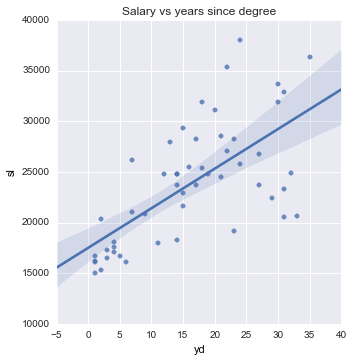

In [26]:
f = sb.lmplot(x = 'yd', y='sl', data=data)
f = plt.title("Salary vs years since degree")

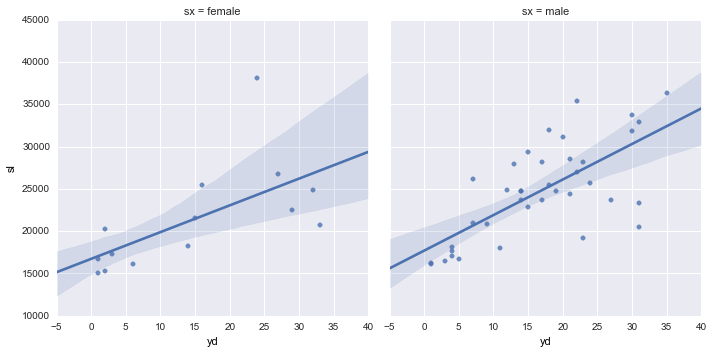

In [27]:
f = sb.lmplot(x = 'yd', y='sl', col='sx', data=data)

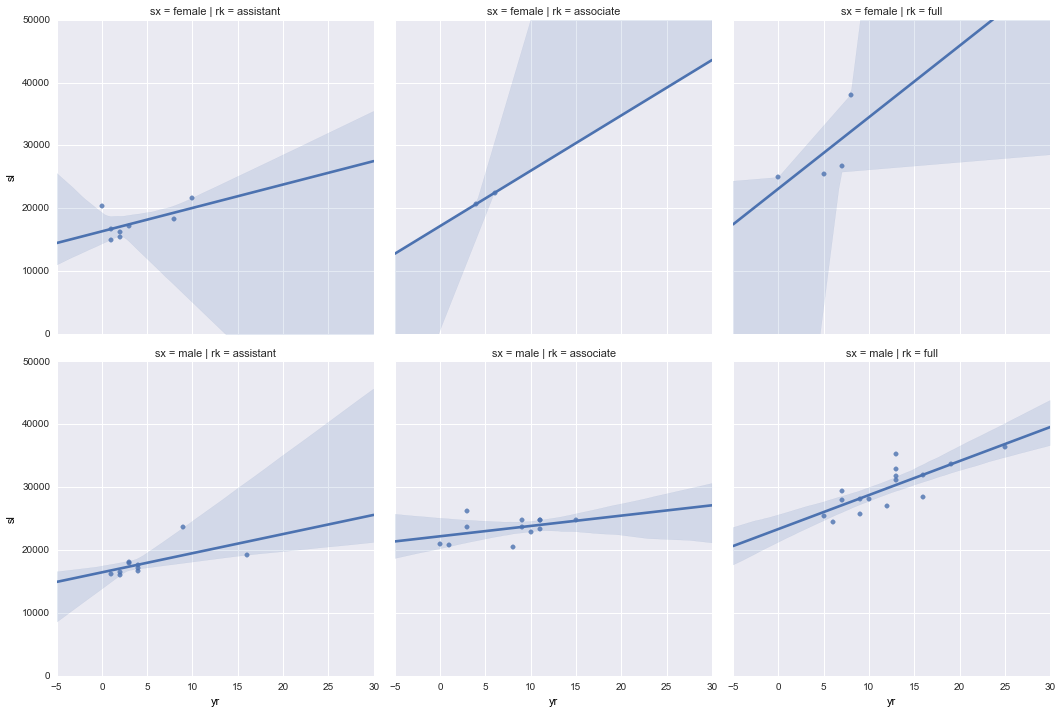

In [28]:
f = sb.lmplot(x = 'yr', y='sl', col='rk', row='sx', data=data)
f = plt.ylim(0, 50000)

Obviously, we're a little short on data to make these last plots convincing.

### Overfitting and regularization

- Note that we haven't looked at cross-validation yet, while supervised problems, like linear regression, always require a training and a testset.
- However, if you have a lot of data, and not so many features, trying to fit all these samples on a single line (or hyperplane in more dimensions) is a strong example of regularization already.
- With many features, few samples, or a complex model (e.g., polynomial regression), overfitting is very likely, though, and not only need you to cross-validate your model, also you need to introduce regularization to make your model simpler.

To keep things digestable, we'll look at all of this in a different notebook.

### Further reading

- [Linear Regression with Python](http://connor-johnson.com/2014/02/18/linear-regression-with-python/)
- [Statsmodels Documentation](http://statsmodels.sourceforge.net/stable/index.html)
- [Python 538 Model](https://github.com/jseabold/538model)

<hr>

## Exercises

####First Anscombe dataset
Have a look at the first Anscombe dataset, and fit a linear model to the data.
- Plot the data
- Fit a linear model
- Find the $R^2$ of the correlation between $x$ and $y$
- Write down the formula $y = ax + b$ and find $a$ and $b$
- Do you think this is a reasonable model for the data?
- Given this model, what $y$ would you expect for a point with $x = 10$?
- (*) Compute the mean absolute error (MAE) and what is the mean square error (MSE)
- (**) Show that indeed, $R^2 = 1 - \text{MSE}/\text{Var}(y)$

In [29]:
data = pd.DataFrame({'x': [10.0, 8.0, 13.0, 9.0, 11.0, 14.0, 6.0, 4.0, 12.0, 7.0, 5.0],
     'y': [8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68]})

In [30]:
# your code here

#### Boston

In this exercise, we'll use one of sklearn's standard datasets to analyze Boston house prices.

In [31]:
from sklearn.datasets import load_boston
boston = load_boston()
X, y = boston.data, boston.target
features = boston.feature_names
# print boston.DESCR  # print this to get information on the dataset

- Let's make a histogram of all house prices in the dataset. 
- It's a little unclear in what units the prices are, let's assume it's in $K.

In [32]:
# your code here

- Find a linear model that fits the data, and with which you feel comfortable.
- Compute the $R^2$ of the model with and without cross-validation
- (*) Compute the MAE and MSE of the model as well
- Prices often behave expontential, rather than linear (people often say +2%, rather than +\$200). Let's try modeling the logarithm of the price and see if that improves your model: `y = np.log(boston.target)` 

- (*) How much more worth would a house be in a crime-free community, compared to the same house in a community with a crime rate of 6 per resident? (Note that this might not be a fair analysis as features might correlate with themselves  as well.)
- (**) What would be a good way of analyzing which feature has the biggest influence on the house price?

In [33]:
# your code here